# Optimization Methods for Data Science

##### Authors: Mojtaba Amini , Kamile Dementaviciute, Saeed Soufeh

##### HW1
##### Deadline: 04/11/2022

In the first part, the random data has been generated.

In [147]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
from time import process_time
import pandas as pd
from sklearn.utils import fixes

Original size of X= 300	Unlabeled size = 294	labeled size = 6
Original size of y= 300	Unlabeled size = 294	labeled size = 6


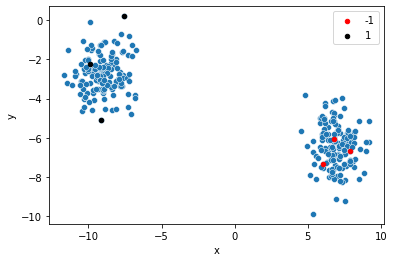

In [148]:
# generate 2d classification dataset
np.random.seed(15)
X, y = make_blobs(n_samples=300, centers=2, n_features=2)
x_Unlabeled ,x_labeled_bar,y1,y_label = train_test_split(X,y,test_size=0.02)

print(f"Original size of X= {X.shape[0]}\tUnlabeled size = {x_Unlabeled.shape[0]}\tlabeled size = {x_labeled_bar.shape[0]}")
print(f"Original size of y= {y.shape[0]}\tUnlabeled size = {y1.shape[0]}\tlabeled size = {y_label.shape[0]}")

y_label=y_label*2-1
df = DataFrame(dict(x=x_labeled_bar[:,0], y=x_labeled_bar[:,1], label=y_label))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
sns.scatterplot(ax=ax,x=X[:,0],y=X[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()



### <mark><b>Similarity Measure function</b></mark>

<ol>
  <li><b>Euclidean Distance</b></li>
  At first, for similarity, the similarity measure function has been defined as below:
  $$ d(x,y) = {e^{\sum_{i=1}^k (x_i-y_i)^2 }}$$

  So the similarity matrix is defined as below:

  $$\omega_{ij}={e^{(x_{1i}-x_{1j})^2+(x_{2i}-x_{2j})^2}}$$

  ${x_1}$ refer to the first dimension and ${x_2}$ is the second dimension in 2D.

  ${i ,j}$ are two indexes for labeled and unlabeled data. 

  Therefore the matrix is as below:

  $$
\omega_{ij}= \begin{bmatrix}
{e^{(x_{11}-x_{11})^2+(x_{21}-x_{21})^2}} & {e^{(x_{11}-x_{12})^2+(x_{21}-x_{22})^2}} & \cdots \\
{e^{(x_{12}-x_{11})^2+(x_{22}-x_{21})^2}} & \ddots & \cdots \\
\vdots & \cdots & \cdots \\
\end{bmatrix}
$$
</ol>

<b>Defining Similarity functions:</b>

In [149]:
def Gaussian_distance(x,y):
  return np.exp(-np.linalg.norm(x-y)**2)

<b> Initializing matrixes</b>

In [150]:
def initialize_parameters(x_Unlabeled):
  np.random.seed(4)
# initialize the parameters with non-zeros numbers between(0,1)
  y_unlabel=np.random.rand(len(x_Unlabeled))*0.01
  return y_unlabel

<b>Defining the similarity matrix</b>

In [151]:
def similarity(x_Unlabeled,x_labeled_bar,type):
  wij=np.zeros((len(x_labeled_bar),len(x_Unlabeled)))
  wij_bar=np.zeros((len(x_Unlabeled),len(x_Unlabeled)))

  if type=="Gaussian" :
    for j in range(len(x_Unlabeled)):
      for i in range(len(x_labeled_bar)):
        wij[i,j] = Gaussian_distance(x_labeled_bar[i,:],x_Unlabeled[j])
      for i in range(len(x_Unlabeled)):
        wij_bar[i,j] = Gaussian_distance(x_Unlabeled[i],x_Unlabeled[j])
  return wij,wij_bar

### <mark><b>Cost function and it's derivative</b></mark>


 Cost function:
  $$ \min_{y\in{R^u}} \sum_{i=1}^l\sum_{j=1}^u \omega_{ij}(y^{j}-\bar{y}^{i})^2 + \frac{1}{2} \sum_{i=1}^u\sum_{j=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})^2 $$

Gradient with respect to $y^{j}$:
$$\nabla_{y^{j}} f(y)=2\sum_{i=1}^l \omega_{ij}(y^{j}-\bar{y}^{i})+2 \sum_{i=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})$$

$u$ : unlabeled data

$l$ : labeled data

$y$ : predicted label ( parameters)

$\bar{y}$ : determined label

$\omega_{ij}$ : similarity measure matrix between labeled and unlabeled data

$\bar{\omega}_{ij}$ : similarity measure matrix between unlabeled data


In [152]:
def cost_function(wij,wij_bar,y_unlabel,y_label):
  cost=0.0

  y_label_matrix = np.tile(y_label,(y_unlabel.shape[0],1))
  y_unlabel_array = np.reshape(y_unlabel,(y_unlabel.shape[0],1))
  wij_reshaped = wij.T
  sub1 = np.power(y_label_matrix-y_unlabel_array,2)
  mat1 = wij_reshaped*sub1
  term1 = np.sum(mat1)

  y_unlabel_matrix = np.tile(y_unlabel,(y_unlabel.shape[0],1))
  y_unlabel_array = np.reshape(y_unlabel,(y_unlabel.shape[0],1))
  wij_bar_reshaped = wij_bar.T
  sub2 = np.power(y_unlabel_matrix-y_unlabel_array,2)
  mat2 = wij_bar_reshaped*sub2
  term2 = np.sum(mat2)

  cost = term1 + 0.5*term2
  return cost

In [153]:
def dev_function(wij,wij_bar,y_unlabel,y_label,method,index=1,size=0):

  if method == "GD":
    size = y_unlabel.shape[0]

  dev = np.zeros(size)

  for j in range(size):
    term1=0.0
    term2=0.0
    
    for i in range(len(y_label)):
      term1 = term1+wij[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_label[i])
    for i in range(len(y_unlabel)):
      term2 = term2+wij_bar[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_unlabel[i])
    dev[j] = 2*(term1 + term2)

  return dev  

### <mark><b>Gradient Descent</b></mark>


In [67]:
alpha=0.003
num_iteration=800
time_tracking = np.zeros(num_iteration)
t1_start = process_time() 

y_unlabel = initialize_parameters(x_Unlabeled)
wij,wij_bar = similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func = np.zeros(num_iteration)


for i in range(num_iteration):
  derivative = dev_function(wij,wij_bar,y_unlabel,y_label,method = "GD")
  y_unlabel = y_unlabel-alpha*derivative
  cost_func[i] = cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking[i] = process_time() - t1_start

Gradient Descend
CPU time: 58.379276778000076


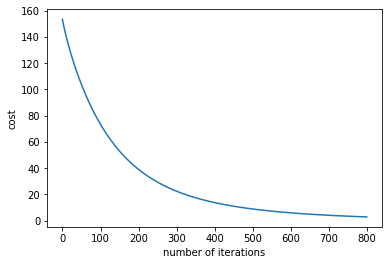

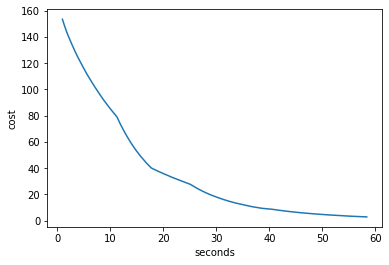

In [68]:
t1_stop = process_time()
print("Gradient Descend")
print("CPU time:", t1_stop - t1_start)

sns.lineplot(x= range(num_iteration),y=cost_func)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x= time_tracking,y=cost_func)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

Visualizing the result to see that the assignment is correct or not!

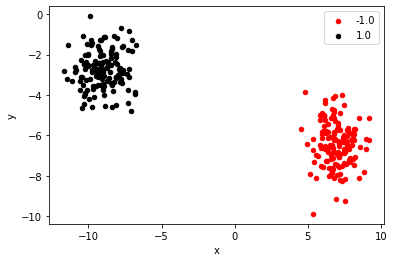

In [69]:
y_unlabel2=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel2))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
# sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### <mark><b>Randomized Block Coordinate Decent</b></mark>

Since we want to be faster, we just want to calculate a part of derivative. Therefore, we change the derivative function for randomized and cyclic. methods.

In [154]:
alpha=0.003
max_iterations=100000
done_iterations = 0
time_tracking = np.zeros(max_iterations)
t1_start = process_time() 

y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func=np.zeros(max_iterations)

Block_size = 1
Num_Block = int(y_unlabel.shape[0]/Block_size)

In [155]:
for i in range(max_iterations):
  Block_index = np.random.randint(1,Num_Block+1)
  derivative = dev_function(wij,wij_bar,y_unlabel,y_label,method = "BCGD",index = Block_index,size = Block_size)
  y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] = y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] \
  -alpha*derivative

  cost_func[i] = cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking[i]  =  process_time() - t1_start
  done_iterations += 1

  dir = - derivative
  gnr = np.dot(derivative, dir) #product of the gradient with the direction

  # checking stopping condition

  # continue if not yet reached target value fstop
  # '''how to set fstop value?'''
  # if cost_func[i] <= 0.5: 
  # break

  # '''how to set a good eps value?'''
  # if abs(len(x_Unlabeled) * gnr) <= 0.5: 
  #   cost_func = cost_func[:i+1]
  #   time_tracking = time_tracking[:i+1]
  #   break 

  # linesearch


t1_stop = process_time()

In [156]:
# print(done_iterations)
# print(time_tracking.shape[0])

100000
100000


Randomized BCGD
CPU time: 188.31036673500012


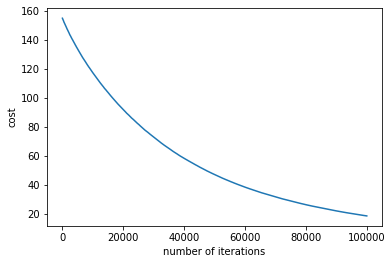

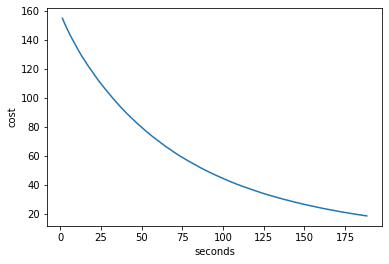

In [157]:
print("Randomized BCGD")
print("CPU time:", t1_stop - t1_start)

sns.lineplot(x = range(done_iterations),y = cost_func)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x = time_tracking, y = cost_func)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

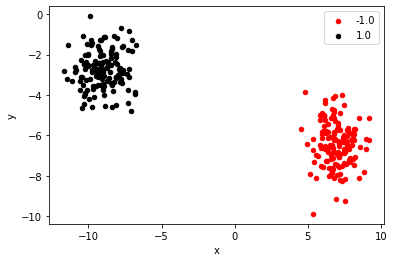

In [ ]:
y_unlabel3=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel3))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### <mark><b>Cyclic Block Coordinate Decent</b></mark>

In [120]:
alpha=0.003
max_iterations=800
done_iterations = 0
time_tracking = np.zeros(max_iterations)
t1_start = process_time() 

y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func=np.zeros(max_iterations)

Block_size=1
Num_Block=int(y_unlabel.shape[0]/Block_size)


In [115]:
fstop = -5
gamma = 0.0001
fx = cost_function(wij,wij_bar,y_unlabel,y_label)

In [121]:
for i in range(max_iterations):
  for Block_index in range(1,Num_Block+1):
    derivative = dev_function(wij,wij_bar,y_unlabel,y_label,method = "BCGD",index = Block_index,size = Block_size)
    y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] = y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] \
    -alpha*derivative

  cost_func[i] = cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking[i]  =  process_time() - t1_start
  done_iterations += 1

  full_deriv = dev_function(wij,wij_bar,y_unlabel,y_label,method = "GD")
  dir = - full_deriv
  gnr = np.dot(full_deriv, dir) #product of the gradient with the direction



  # checking stopping condition

  # continue if not yet reached target value fstop
  '''how to set fstop value?'''
  if cost_func[i] <= 0.5: 
    break

  '''set a good eps value'''
  if abs(len(x_Unlabeled) * gnr) <= 10: 
    cost_func = cost_func[:i+1]
    time_tracking = time_tracking[:i+1]
    break 


  # linesearch
  # Armijo search
  # alpha = 1.0
  # ref = gamma * gnr

  # while 1:
  '''whats the fz function for our specific case?'''
  #   fz = fx + alpha * full_deriv * fx + 0.5 * (alpha * dir) ^2 * Qii
    
  #   if (fz<=fx+alpha*ref)
  #       z(ind)=x(ind)+alpha*d;
  #       break;
  #   else
  #       alpha=alpha*0.1;
  #   end
    
  #   if (alpha <= 1e-20)
  #       z=x;
  #       fz=fx;
  #       flagls=1;
  #       it = it-1;
  #       break;



t1_stop = process_time()

BCGD with Cyclic Rule
CPU time: 100.88510026299991


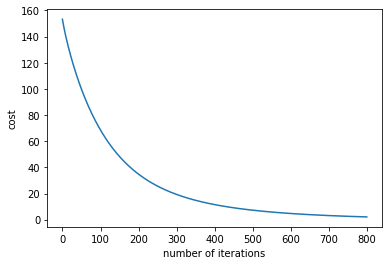

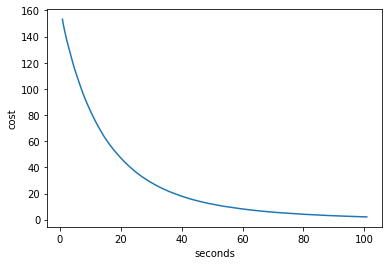

2.175068777336982


In [123]:
print("BCGD with Cyclic Rule")
print("CPU time:", t1_stop - t1_start)

sns.lineplot(x = range(done_iterations),y = cost_func)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x = time_tracking, y = cost_func)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

print(cost_func[-1])

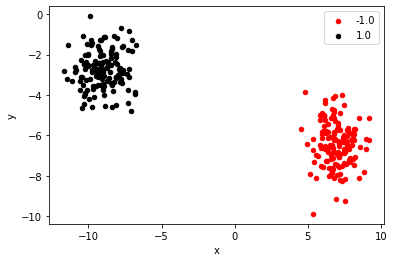

In [74]:
y_unlabel3=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel3))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [ ]:
'''Line Search'''


#         linesearch
        
#         set z=x
#         z=x;
#         switch arls
#             case 1
                
#                 Armijo search
#                 alpha=1.0;
#                 ref = gamma*gnr;
                
#                 while(1)
#                     z(ind)=x(ind)+alpha*d;
                    
#                     Smart computation of the o.f. at the trial point
#                     fz = fx+alpha*d*gi+0.5*(alpha*d)^2*Qii;
                    
#                     if (fz<=fx+alpha*ref)
#                         z(ind)=x(ind)+alpha*d;
#                         break;
#                     else
#                         alpha=alpha*0.1;
#                     end
                    
#                     if (alpha <= 1e-20)
#                         z=x;
#                         fz=fx;
#                         flagls=1;
#                         it = it-1;
#                         break;
#                     end
                    
#                 end
                
#             otherwise
#                 exact alpha
#                 alpha=1/Qii;
#                 z(ind)=x(ind)+alpha*d;
#                 fz = fx+alpha*d*gi+0.5*(alpha*d)^2*Qii;   
#         end


# arls: line search (1 Armijo 2 exact)
# maxit: maximum number of iterations
# eps: tolerance
# fstop: target o.f. value
# stopcr: stopping condition